In [151]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from scipy import ndimage
import sklearn
from scipy.ndimage import zoom
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import shift
from scipy.ndimage import map_coordinates
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [65]:
# Image size for resizing
image_size = (128, 128)  # Adjust based on your preference or model requirements

# Function to load images and labels
def load_data(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sort to ensure consistent label ordering
    class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for image_name in tqdm(os.listdir(class_folder)):
            image_path = os.path.join(class_folder, image_name)
            try:
                # Read and resize image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    image = image[:,:,0]
                    image = image.reshape(128, 128, 1)
                    images.append(image)
                    labels.append(class_to_label[class_name])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    
    return np.array(images), np.array(labels), class_to_label

# Load the dataset
x_train, y_train, class_mapping_train = load_data('/mnt/c/Users/Dhruba/Data/OCTDL/train')
x_test, y_test, class_mapping_test = load_data('/mnt/c/Users/Dhruba/Data/OCTDL/test')

# Normalize images (optional, recommended for deep learning)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset details
print(f"x_training data shape: {x_train.shape} and test data shape: {x_test.shape}: ")
print(f"x_training label shape: {y_train.shape} and test label shape: {y_test.shape}: ")
print(f"Class mapping: {class_mapping_train}")

# y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("Train label shape:", y_train.shape)
print("Test encoded label shape:", y_test_encoded.shape)

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 19.18it/s]


x_training data shape: (1635, 128, 128, 1) and test data shape: (429, 128, 128, 1): 
x_training label shape: (1635,) and test label shape: (429,): 
Class mapping: {'AMD': 0, 'DME': 1, 'ERM': 2, 'NO': 3, 'RAO': 4, 'RVO': 5, 'VID': 6}
Train label shape: (1635,)
Test encoded label shape: (429, 7)


In [11]:
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_data.npy', x_test)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_label_enc.npy', y_test_encoded)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_data.npy', x_train)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_label.npy', y_train)

In [2]:
## for train and test with 90:10 ratio analysis load them ##
# x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_data.npy')
# y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Test/test_label_enc.npy')
# x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_data.npy')
# y_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/Raabin WBC/Train/train_label.npy')

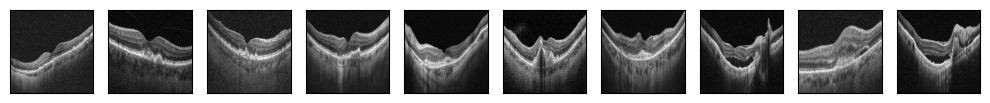

In [70]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
plt.show()

In [13]:
# ## Perform horizontal and vertical flips
# x_train_hflip = np.flip(x_train[0:212], axis=2)  # Horizontal flip (flip along width)
# y_train_hflip = y_train[0:212]
# x_train_vflip = np.flip(x_train[0:212], axis=1)  # Vertical flip (flip along height)
# y_train_vflip = y_train[0:212]

# ## Combine original and augmented data
# x_train_augmented = np.concatenate((x_train, x_train_hflip, x_train_vflip), axis=0)
# y_train_augmented = np.concatenate((y_train, y_train_hflip, y_train_vflip), axis=0)

# # Check the shapes for confirmation
# print("Original dataset shape:", x_train.shape)
# print("Augmented dataset shape:", x_train_augmented.shape)
# print("Augmented label shape:", y_train_augmented.shape)
# del x_train_hflip
# del x_train_vflip

Original dataset shape: (10175, 128, 128, 3)
Augmented dataset shape: (10599, 128, 128, 3)
Augmented label shape: (10599,)


In [71]:
def translate_image(image, shift_x, shift_y):
    """
    Translate the image by shift_x and shift_y.
    Uses constant fill for pixels outside boundaries.
    """
    return shift(image, shift=(shift_y, shift_x, 0), mode='constant', cval=0.0)

# Create translated datasets
x_train_translated_pos = np.array([translate_image(img, 20, 20) for img in tqdm(x_train[1480:])])  # +20 pixels in both directions
y_train_tpos = y_train[1480:]
x_train_translated_neg = np.array([translate_image(img, -20, -20) for img in tqdm(x_train[1480:])])  # -20 pixels in both directions
y_train_tneg = y_train[1480:]

# Combine original and translated data
x_train_augmented = np.concatenate((x_train, x_train_translated_pos, x_train_translated_neg), axis=0)
y_train_augmented = np.concatenate((y_train, y_train_tpos, y_train_tneg), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)
del x_train_translated_pos
del x_train_translated_neg

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:01<00:00, 137.50it/s]


Original dataset shape: (1635, 128, 128, 1)
Augmented dataset shape: (1945, 128, 128, 1)
Augmented label shape: (1945,)


100%|██████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:06<00:00, 257.12it/s]


(6540, 128, 128, 1)
(6540,)
Original dataset shape: (1635, 128, 128, 1)
Augmented dataset shape: (8485, 128, 128, 1)
Augmented label shape: (8485,)


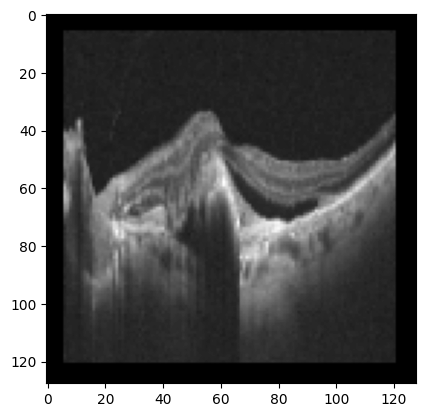

In [78]:
def scaleit(image, factor, isseg=False):
    order = 0 if isseg == True else 1
    height, width = image.shape[:2]   
# For multichannel images we don't want to apply the zoom factor to the channel dimension, so instead we create a tuple of zoom 
# factors, one per array dimension, with 1's for any trailing dimensions after the width and height.  
    zoom_tuple = (factor,)*2 + (1,)*(image.ndim - 2) 
    
    if factor < 1.0:
        zheight = int(np.round(factor * height))
        zwidth  = int(np.round(factor * width))
        newimg  = np.zeros_like(image)
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        newimg[row:row+zheight, col:col+zwidth] = zoom(image, zoom_tuple, order=order, mode='nearest')
        return newimg
    
    elif factor > 1.0:
        zheight = int(np.round(height / factor))
        zwidth  = int(np.round(width / factor))
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        
        newimg = zoom(image[row:row+zheight, col:col+zwidth], zoom_tuple, order=order, mode='nearest')
# `newimg` might still be slightly larger than `img` due to rounding, so trim off any extra pixels at the edges
        trim_row = ((newimg.shape[0] - height) // 2)
        trim_col = ((newimg.shape[1] - width) // 2)
        newimg = newimg[trim_row:trim_row+height, trim_col:trim_col+width]
        return newimg
    
# If zoom_factor == 1, just return the input array
    else:
        return image

img_aug_array=[]
label_array = []
zoom_factor = [0.90, 0.95, 1.05, 1.10]
for d in tqdm(range(x_train.shape[0])): 
    for e in range (4):
            volume = scaleit(x_train[d], zoom_factor[e], isseg=False)
            img_aug_array.append(volume)
            label = y_train[d]
            label_array.append(label)
        
x_train_scaled = np.array(img_aug_array, np.float32)
print(x_train_scaled.shape)
y_train_scaled = np.array(label_array, np.float32)
print(y_train_scaled.shape)

plt_case = 1000
plt.imshow(x_train_scaled [plt_case][:,:,0], cmap='gray')


# Combine original and scaled datasets
x_train_augmented = np.concatenate((x_train_augmented, x_train_scaled), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_train_scaled), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train.shape)
print("Augmented dataset shape:", x_train_augmented.shape)
print("Augmented label shape:", y_train_augmented.shape)

In [83]:
angles = np.arange(-40, 41, 5)
img_aug_array= []
label_array = []

for d in tqdm(range(x_train.shape[0])): 
    for e in range (17):
            volume = ndimage.rotate(x_train[d], angles[e], reshape=False, order=1) 
            img_aug_array.append(volume)
            label = y_train[d]
            label_array.append(label)
        
x_aug_ang = np.array(img_aug_array, np.float32)
print(x_aug_ang.shape)
y_aug_ang = np.array(label_array, np.float32)
print(y_aug_ang.shape)

# Combine original and scaled datasets
x_train_augmented = np.concatenate((x_train_augmented, x_aug_ang), axis=0)
y_train_augmented = np.concatenate((y_train_augmented, y_aug_ang), axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1635/1635 [00:15<00:00, 107.20it/s]


(27795, 128, 128, 1)
(27795,)


In [95]:
y_train_encoded = to_categorical(y_train_augmented)
print(x_train_augmented.shape)
print(y_train_encoded.shape)

(36280, 128, 128, 1)
(36280, 7)


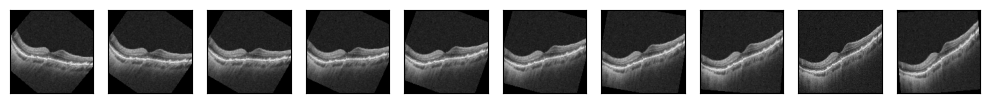

In [88]:
# plt.figure(figsize=(10,5))
# for i in range(10):
#     plt.subplot(1,10,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()
#     plt.grid(False)
#     plt.imshow(x_aug_ang[i], cmap='gray')
# plt.show()

In [89]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x

def DenseNet121(input_shape=(128, 128, 1), num_classes=7):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = DenseNet121()
#model.summary()

I0000 00:00:1736276217.094753     414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736276217.366912     414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736276217.367069     414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736276217.382734     414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736276217.382886     414 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [91]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip((y_true) * (y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives + K.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) 
    return true_negatives / (possible_negatives + K.epsilon())

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
    
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=10000,
    decay_rate=0.1) #should be < 1, otherwise lr rate increases

optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)


model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])  ##if not one-hot encoded use: SparseCategoricalCrossentropy

In [96]:
filepath = '/mnt/c/Users/Dhruba/Codes/saved models/OCTDL_wght_dns.ep{epoch:02d}-test_acc_{val_accuracy:.3f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

y_train_int = np.argmax(y_train_encoded, axis=1)
## Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

result = model.fit(x=x_train_augmented,
                    y=y_train_encoded,
                    batch_size = 50,
                    epochs = 30,
                    verbose = 1,
                    validation_data = (x_test, y_test_encoded),
                    callbacks=[checkpoint],
                    class_weight=class_weights_dict,### results in poor accuracy 
                    shuffle=True)

Class Weights: {0: 0.24039226080042406, 1: 2.03090013434841, 2: 1.931019799872259, 3: 0.8844466114090688, 4: 13.49702380952381, 5: 2.8045763760049476, 6: 3.7233169129720856}
Epoch 1/30


I0000 00:00:1736276533.938068    3205 service.cc:146] XLA service 0x7fb504002bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736276533.938170    3205 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-01-07 13:02:15.308796: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-07 13:02:20.539224: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-07 13:03:41.189510: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_59', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1736276621.668166    3205 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

725/726 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2855 - loss: 2.2172

2025-01-07 13:05:56.165992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_3', 8 bytes spill stores, 8 bytes spill loads



726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2856 - loss: 2.2163

2025-01-07 13:06:01.229371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 13:06:01.565228: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2025-01-07 13:06:01.702251: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 236 bytes spill stores, 236 bytes spill loads

2025-01-07 13:06:06.195156: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2025-01-07 13:06:06.222725: I external/local_xla/xla/stream_ex


Epoch 1: val_accuracy improved from -inf to 0.36131, saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_wght_dns.ep01-test_acc_0.361.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 285s 211ms/step - accuracy: 0.2858 - loss: 2.2154 - val_accuracy: 0.3613 - val_loss: 2.0033
Epoch 2/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6649 - loss: 0.7780
Epoch 2: val_accuracy improved from 0.36131 to 0.60839, saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_wght_dns.ep02-test_acc_0.608.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 54s 73ms/step - accuracy: 0.6650 - loss: 0.7778 - val_accuracy: 0.6084 - val_loss: 6.1986
Epoch 3/30
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8102 - loss: 0.3991
Epoch 3: val_accuracy improved from 0.60839 to 0.68998, saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_wght_dns.ep03-test_acc_0.690.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 56s 77ms/step - accuracy: 0.8103 - loss: 0.3991 - val_accuracy: 0.6900 - val_loss: 1.8813
Epoch 4/30
72

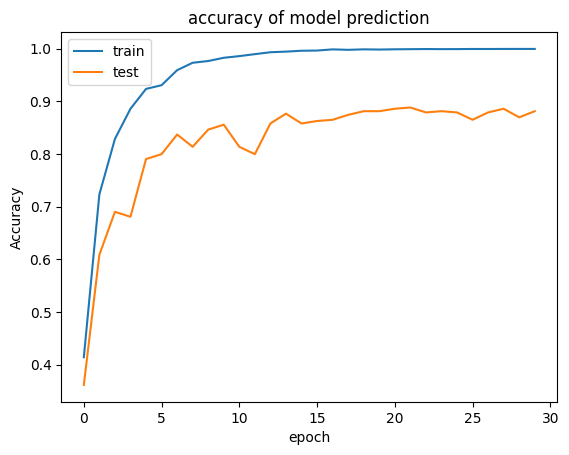

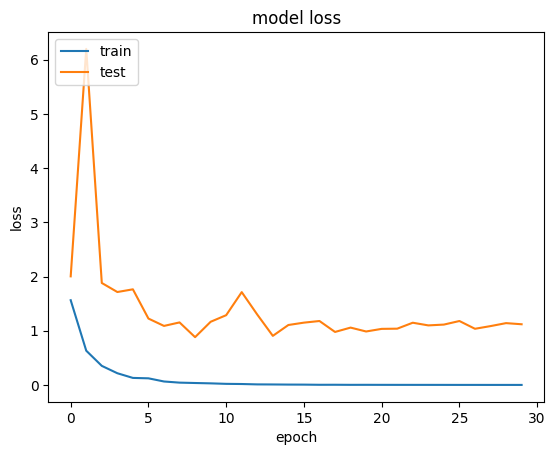

In [97]:
# list all data in history
# summarize history for loss
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('accuracy of model prediction')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/OCTDL_wght_dns.ep22-test_acc_0.888.keras', compile = True)
#best_model.summary()

In [115]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      8,320 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,896 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 96)               │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     12,416 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]  

 Total params: 20,970,454 (80.00 MB)

 Trainable params: 6,962,951 (26.56 MB)

 Non-trainable params: 81,600 (318.75 KB)

 Optimizer params: 13,925,903 (53.12 MB)

In [109]:
best_model.evaluate(x_test, y_test_encoded, batch_size=50, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 356ms/step - accuracy: 0.9207 - loss: 0.4706


[0.9056878685951233, 0.8764568567276001]

In [110]:
y_pred = best_model.predict(x_test, batch_size=50,  verbose=0)

sparse_gt = np.argmax(y_test_encoded, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
#print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)
# # Calculate precision, recall, and F1-score for each class
# precision = precision_score(y, sparse_pred, average=None)
# recall = recall_score(y, sparse_pred, average=None)
# f1 = f1_score(y, sparse_pred, average=None)

# # Calculate macro, micro, and weighted scores
# macro_f1 = f1_score(y, sparse_pred, average='macro')
# micro_f1 = f1_score(y, sparse_pred, average='micro')
# weighted_f1 = f1_score(y, sparse_pred, average='weighted')

Accuracy of model on full test data:  0.8764568764568764
Macro-averaged AUC on full test data:  0.9769844086350963
Micro-averaged AUC on full test data:  0.9865944726084585


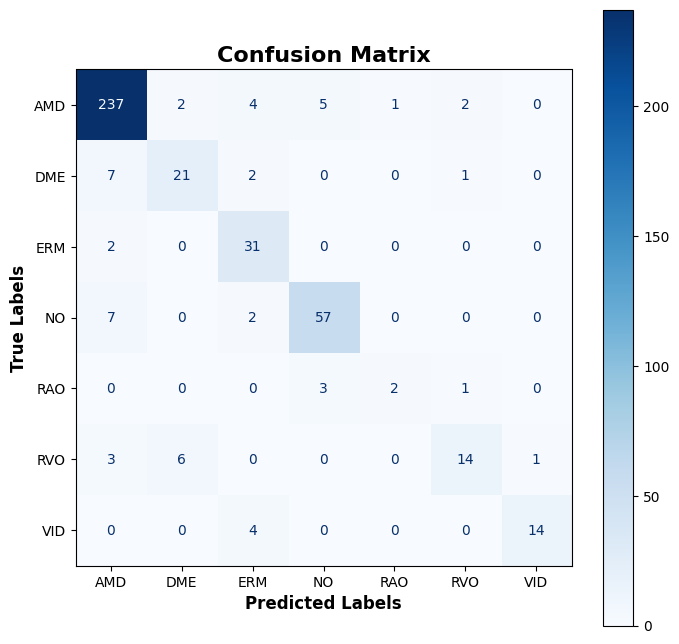

In [111]:
class_names = ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']
plt.figure(figsize=(8, 8))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
## Rotate x-axis labels
plt.xticks(rotation=0)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')

#plt.tight_layout()
plt.show()

In [112]:
# Print classification report
report = classification_report(sparse_gt, sparse_pred, target_names=[f"Class {i}" for i in range(7)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.94      0.93       251
     Class 1       0.72      0.68      0.70        31
     Class 2       0.72      0.94      0.82        33
     Class 3       0.88      0.86      0.87        66
     Class 4       0.67      0.33      0.44         6
     Class 5       0.78      0.58      0.67        24
     Class 6       0.93      0.78      0.85        18

    accuracy                           0.88       429
   macro avg       0.80      0.73      0.75       429
weighted avg       0.88      0.88      0.87       429



In [277]:
# Grad-CAM implementation
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    # print(heatmap)
    return heatmap

# Function to display heatmap on the original image
def display_gradcam(img, heatmap, alpha=0.4):
    #img = load_img(image_path)
    img = img
    heatmap = np.uint8(1 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = np.squeeze(heatmap)
    heatmap = plt.cm.jet(heatmap)[:, :, :3]  # Use jet colormap for visualization
    overlay = (img) + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)
    return overlay

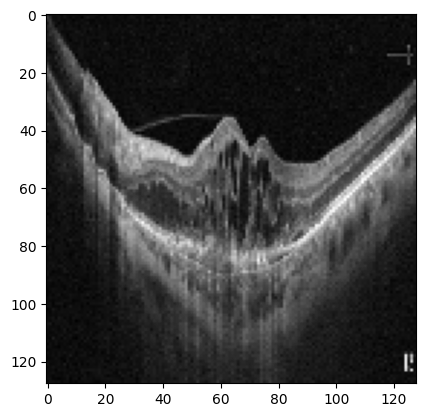

In [122]:
plt.imshow(x_test[0], cmap='gray')

In [ ]:
n = 5
heatmap = make_gradcam_heatmap(best_model, x_test[n], last_conv_layer_name='conv2d_119')  # Replace with the correct layer name for DenseNet-121

# Overlay heatmap and display
overlay = display_gradcam(x_test[n], heatmap)
plt.imshow(overlay)
plt.axis('off')
plt.show()